# Multivariate Time Series Clustering

### Inspired by https://www.kaggle.com/code/izzettunc/introduction-to-time-series-clustering#3.-Libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from tslearn.clustering import TimeSeriesKMeans
import numpy as np

## Load data

In [2]:
ts1_df = pd.read_csv('../data/devices1.csv')
ts2_df = pd.read_csv('../data/devices2.csv')
ts3_df = pd.read_csv('../data/devices3.csv')
ts4_df = pd.read_csv('../data/devices4.csv')
data = pd.concat([ts1_df, ts2_df, ts3_df, ts4_df], axis = 0, ignore_index = True)

In [3]:
data.head()

,battery_voltage,current,current_in,current_out,panel_voltage,state_of_charge_percent,temperature,timestamp,usb_current,voltage,battery_id
0,7.090,-2.542,2.544,0.002,7.240,NaN,NaN,2021-03-02 06:33:24,0.002,7.185,0
1,7.100,-2.548,2.550,0.002,7.245,NaN,NaN,2021-03-02 06:35:24,0.002,7.190,0
2,7.095,-2.472,2.474,0.002,7.275,NaN,NaN,2021-03-02 06:37:24,0.002,7.215,0
3,7.070,-2.232,2.236,0.004,7.370,NaN,NaN,2021-03-02 06:39:24,0.002,7.290,0
4,7.075,-2.276,2.278,0.002,7.350,100.0,28.287938,2021-03-02 06:41:24,0.002,7.280,0


## Inputs

In [4]:
variables_to_analyse = ["battery_voltage", "current"]
frequency = "weekly"  # Either daily, weekly, monthly or seasonally

## Battery Voltage Analysis

### Preprocessing

#### Data preparation

In [5]:
# Converting data timestamp in datetime objects
data.timestamp = pd.to_datetime(data.timestamp)

# Keeping only studied variables
data = data[["timestamp", "battery_id"] + variables_to_analyse]

# Setting date column as index
data.set_index("timestamp", inplace=True)

#### Selecting time frame

In [6]:
# TODO selecting specific time intervals
begin_dt = "2021-05-02 00:00:00"
end_dt = "2021-05-08 23:59:59"

# Selecting study time intervals
data = data.loc[(data.index > pd.Timestamp(begin_dt)) & (data.index < pd.Timestamp(end_dt))]

In [7]:
bat_df = []  # List to store every battery dataframe

for i in range(len(data.battery_id.unique())):
    bat_df.append(data.loc[data.battery_id == i][variables_to_analyse])  # Storing specific battery id dataframe

#### Standardizing size

##### Finding longest time series

In [8]:
series_lengths = {len(series) for series in bat_df}  # Serie length of every battery dataframe
max_len = max(series_lengths)  # max lenght amongst all series
longest_series = None

for series in bat_df:
    if len(series) == max_len:
        longest_series = series

##### Normalizing size

In [9]:
problems_index = []  # Finding battery indexes that need to be re-indexed to the longest time serie

for i in range(len(bat_df)):
    # Time series that aren't as long as the largest one need to be reindexed
    if len(bat_df[i]) != max_len:
        problems_index.append(i)
        # Values are reindexed to the nearest (1 min tolerance) time index of the longest time serie
        bat_df[i] = bat_df[i].reindex(index=longest_series.index, method='nearest', tolerance='1min')

##### Dealing with NaN values

In [10]:
# Values who couldn't be reindexed or gaps are filled using interpolation
for i in problems_index:
    bat_df[i].interpolate(limit_direction="both", inplace=True)

### K-means clustering

#### Choosing number of clusters

In [11]:
# Rule of thumb : choosing k as the square root of the number of points
# cluster_count = math.ceil(math.sqrt(len(bat_df)))
cluster_count = 6

#### Fit k-means clustering

In [12]:
# Time series specific clustering algorithm
km = TimeSeriesKMeans(n_clusters=cluster_count, metric="euclidean")  # dtw metric takes way too long...

# Predict closest cluster for each time series
labels = km.fit_predict(bat_df)
labels

array([3, 4, 3, 2, 2, 1, 3, 4, 2, 0, 0, 4, 4, 1, 5, 0, 1, 3, 0, 2, 1, 1,
       2, 0, 4, 1, 3, 4, 4, 5, 4, 1, 2, 3, 2, 0, 1, 2, 2, 0, 0, 3, 2, 4,
       2, 2, 4, 5, 4, 2, 3, 2, 2, 4, 1, 4, 2, 4, 3, 4, 4, 0, 3, 2, 2, 2,
       4, 4, 3, 2, 2, 4, 4, 1, 2, 1, 4, 3, 2, 2, 0, 4, 3, 4, 5, 2, 1, 1,
       4, 0, 4, 4, 3, 2, 1, 4, 2, 2, 1, 3, 4, 1, 1, 4, 4, 4, 4, 4, 4, 1,
       1, 3, 1, 1, 0, 0, 1, 4, 4, 2, 5, 2, 2, 4, 4, 1, 4, 0, 3, 5, 1, 2,
       2, 2, 2, 1, 1, 3, 4, 3, 4, 0, 3, 2, 4, 4, 2, 3, 4, 1, 1, 1, 1, 1,
       3, 4, 3, 1, 3, 4, 4, 0, 2, 1, 0, 5, 3, 1, 1, 3, 4, 1, 1, 1, 1, 1,
       4, 1, 2, 1, 1, 5, 2, 3, 3, 2, 4, 2, 3, 1, 3, 3, 1, 1, 0, 3, 4, 2,
       5, 2], dtype=int64)

##### Results

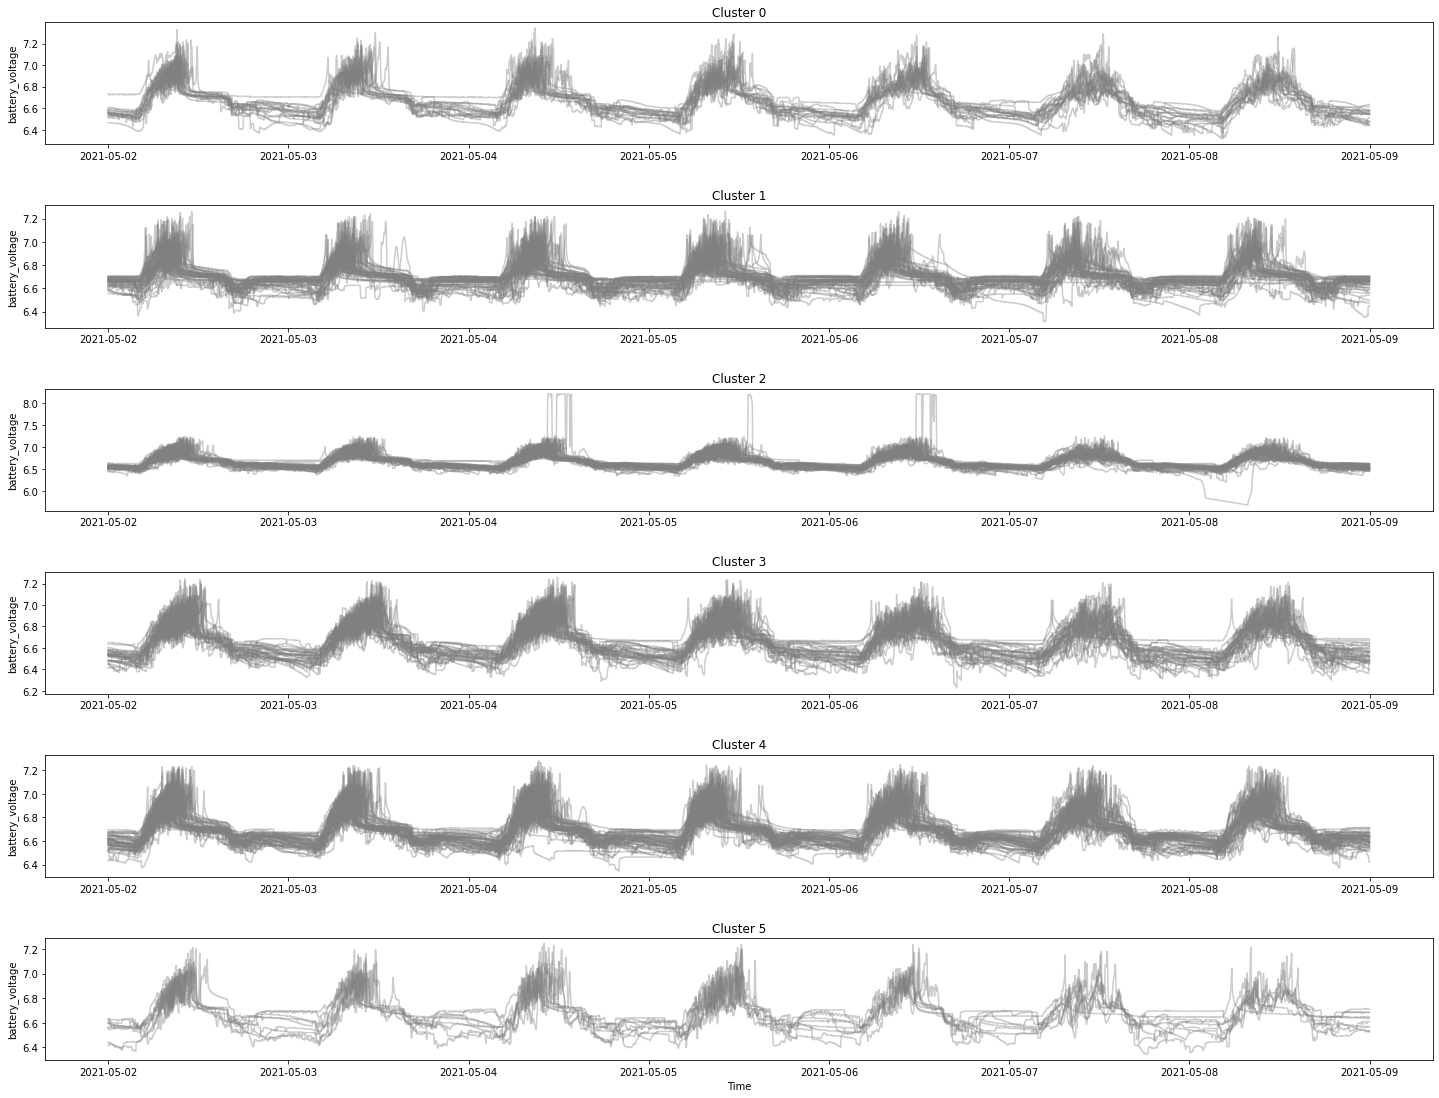

In [13]:
# Larger plots showing inline
plt.rcParams["figure.figsize"] = (20,15)

fig, axs = plt.subplots(len(set(labels)))
fig.tight_layout()

variable_to_plot = "battery_voltage"

for label in set(labels):
    for i in range(len(data.battery_id.unique())):
        if(labels[i]==label):
            axs[label].set_title("Cluster {}".format(label))
            axs[label].set_ylabel(variable_to_plot)
            axs[label].plot(bat_df[i][variable_to_plot], c="gray", alpha=0.4)
#     axs[label].plot(longest_series.index, km.cluster_centers_[label], c="red")
plt.xlabel("Time")
plt.subplots_adjust(hspace=0.5)

In [14]:
bat_df[i]

,battery_voltage,current
timestamp,,
2021-05-02 00:00:16,6.50,0.404
2021-05-02 00:02:16,6.50,0.404
2021-05-02 00:04:16,6.50,0.404
2021-05-02 00:06:16,6.50,0.404
2021-05-02 00:08:16,6.50,0.404
...,...,...
2021-05-08 23:50:40,6.49,0.406
2021-05-08 23:52:40,6.49,0.406
2021-05-08 23:54:40,6.49,0.406


In [15]:
km.cluster_centers_

array([[[6.56305556, 0.30644444],
        [6.56166667, 0.31266667],
        [6.56138889, 0.31622222],
        ...,
        [6.53736111, 0.25866667],
        [6.53694444, 0.25855556],
        [6.53666667, 0.25933333]],

       [[6.65478261, 0.05795652],
        [6.6548913 , 0.05778261],
        [6.6548913 , 0.05717391],
        ...,
        [6.64532609, 0.06343478],
        [6.64532609, 0.06352174],
        [6.64532609, 0.06347826]],

       [[6.54534091, 0.32804545],
        [6.54488636, 0.32972727],
        [6.54295455, 0.34222727],
        ...,
        [6.53852273, 0.34390909],
        [6.53909091, 0.33731818],
        [6.53875   , 0.33681818]],

       [[6.53265625, 0.357625  ],
        [6.53203125, 0.3574375 ],
        [6.5315625 , 0.3559375 ],
        ...,
        [6.5378125 , 0.272375  ],
        [6.536875  , 0.2759375 ],
        [6.53640625, 0.2750625 ]],

       [[6.59715686, 0.24788235],
        [6.59735294, 0.24509804],
        [6.59813725, 0.23870588],
        ...,
        [

(array([18., 46., 44., 32., 51.,  9.]),
 array([0.        , 0.83333333, 1.66666667, 2.5       , 3.33333333,
        4.16666667, 5.        ]),
 <BarContainer object of 6 artists>)

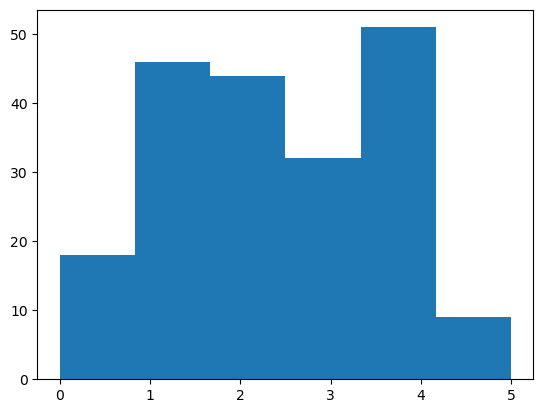

In [16]:
# Reseting stylesheet
plt.rcParams.update(plt.rcParamsDefault)

# Distribution of time series in clusters
plt.hist(labels, bins=cluster_count)